In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [2]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.001
training_iters = 26000000
batch_size = 64
display_step = 2000
display_testing_step = 400
keep_rate = 1

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 512 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [8]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [9]:
tf.reset_default_graph()

tf.set_random_seed(0.5)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, n_classes], stddev=st_dev, seed=0.5))
}

b = {
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [10]:
num_layers = 1

def RNN(x, W, b):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

        
    lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)

                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']



In [11]:

pred = RNN(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [12]:
# Initializing the variables
init = tf.global_variables_initializer()


In [13]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    losses = {'train':[], 'validation':[]}
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)
        
        # Generate minibatches for training and validating.
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
        batch_val_y = y_test[offset_val:(offset_val + batch_size), :]
        
        # Reshape data to feed into RNN
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y})

        if step % display_step == 0:

            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                  "{:.6f}".format(loss_test)
                        
        losses['train'].append(loss)
        losses['validation'].append(loss_test)
        step += 1
            
    print("Optimization Finished!")

    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)
    
    

Iter 128000, Minibatch Loss= 0.000216, Minibatch Val Loss= 6.075318
Iter 256000, Minibatch Loss= 0.000061, Minibatch Val Loss= 0.000061
Iter 384000, Minibatch Loss= 0.000016, Minibatch Val Loss= 0.001923
Iter 512000, Minibatch Loss= 0.000223, Minibatch Val Loss= 0.412617
Iter 640000, Minibatch Loss= 0.004457, Minibatch Val Loss= 0.000152
Iter 768000, Minibatch Loss= 0.000014, Minibatch Val Loss= 0.033025
Iter 896000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 1024000, Minibatch Loss= 0.000168, Minibatch Val Loss= 0.912204
Iter 1152000, Minibatch Loss= 0.000023, Minibatch Val Loss= 0.000023
Iter 1280000, Minibatch Loss= 0.000007, Minibatch Val Loss= 1.248947
Iter 1408000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.808854
Iter 1536000, Minibatch Loss= 0.001544, Minibatch Val Loss= 2.880591
Iter 1664000, Minibatch Loss= 0.000006, Minibatch Val Loss= 1.091390
Iter 1792000, Minibatch Loss= 0.000003, Minibatch Val Loss= 0.000003
Iter 1920000, Minibatch Loss= 0.000000, M

Iter 15360000, Minibatch Loss= 0.007560, Minibatch Val Loss= 0.006245
Iter 15488000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15616000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15744000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 15872000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16000000, Minibatch Loss= 0.000000, Minibatch Val Loss= 11.256081
Iter 16128000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16256000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16384000, Minibatch Loss= 0.000001, Minibatch Val Loss= 0.000214
Iter 16512000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 16640000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000003
Iter 16768000, Minibatch Loss= 0.000000, Minibatch Val Loss= 2.758915
Iter 16896000, Minibatch Loss= 0.000000, Minibatch Val Loss= 0.000000
Iter 17024000, Minibatch Loss= 0.000000, Minibatch Val Loss= 6.956640
Iter 17152000, Mini

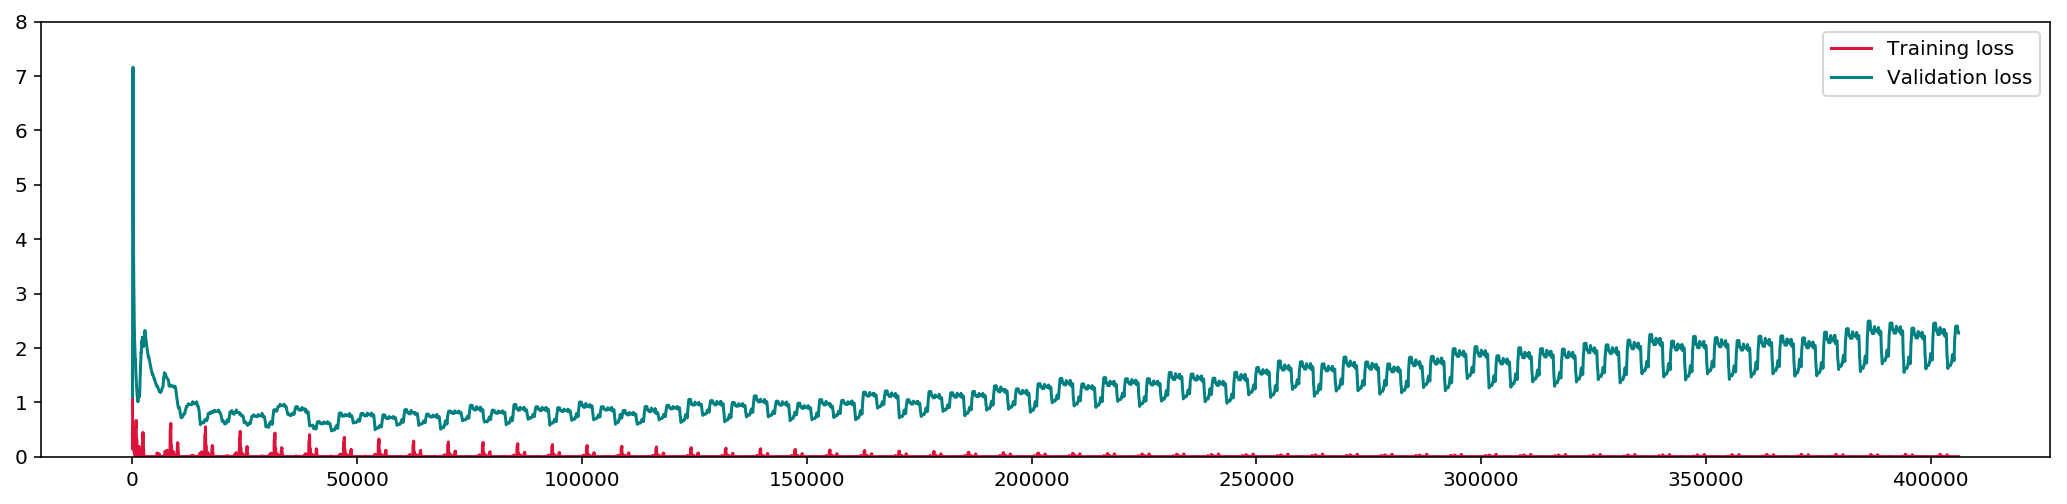

In [15]:

smoothed_loss = hm.running_mean(losses['train'], 200)
smoothed_loss_train = hm.running_mean(losses['validation'], 8000)
fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([0,8])
plt.show()

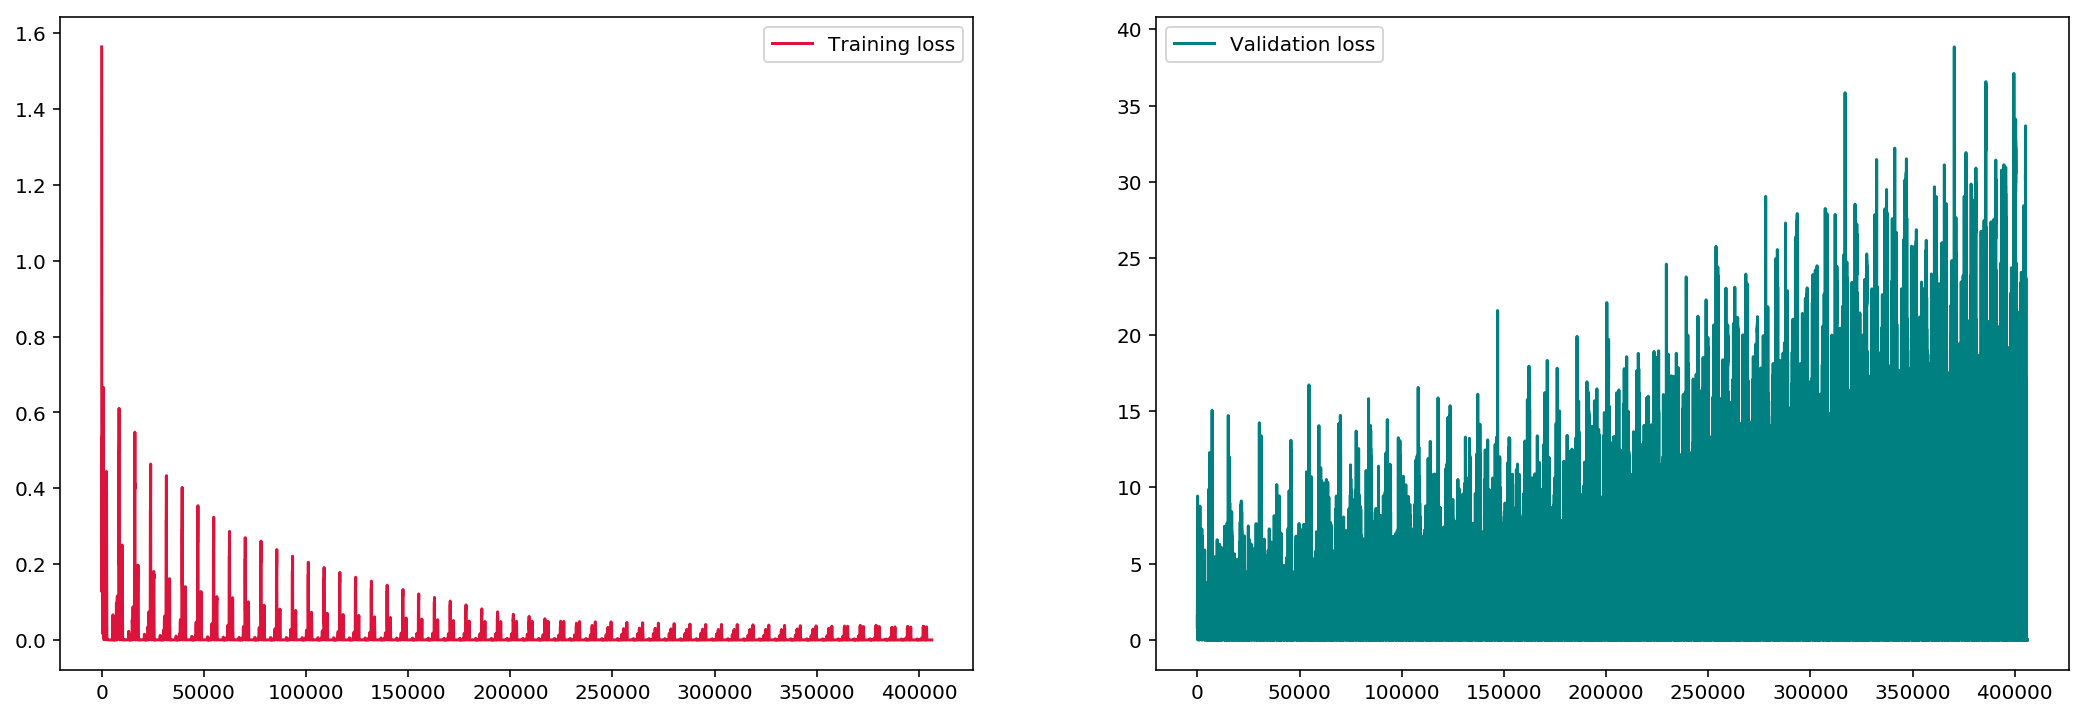

In [16]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

smoothed_loss = hm.running_mean(losses['train'], 200)

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()


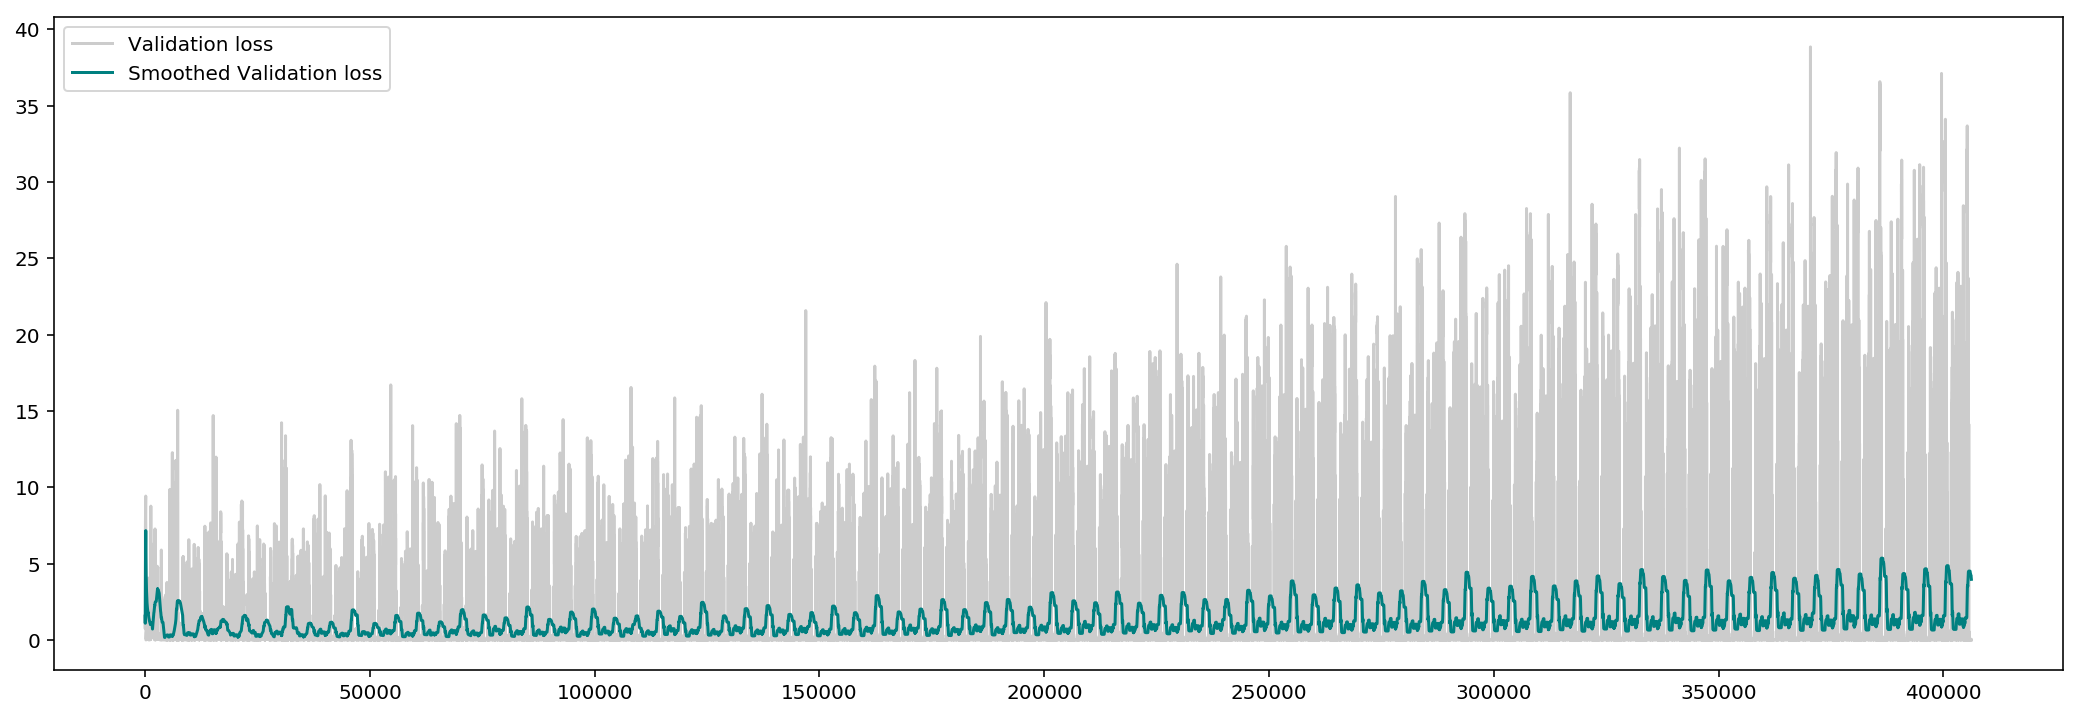

In [17]:

non_smoothed_loss_train = hm.running_mean(losses['validation'], 1)
smoothed_loss_train = hm.running_mean(losses['validation'], 1500)

fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(non_smoothed_loss_train, label='Validation loss', color='gray', alpha=0.4)
ax1.plot(smoothed_loss_train, label='Smoothed Validation loss', color='teal')
ax1.legend()
plt.show()



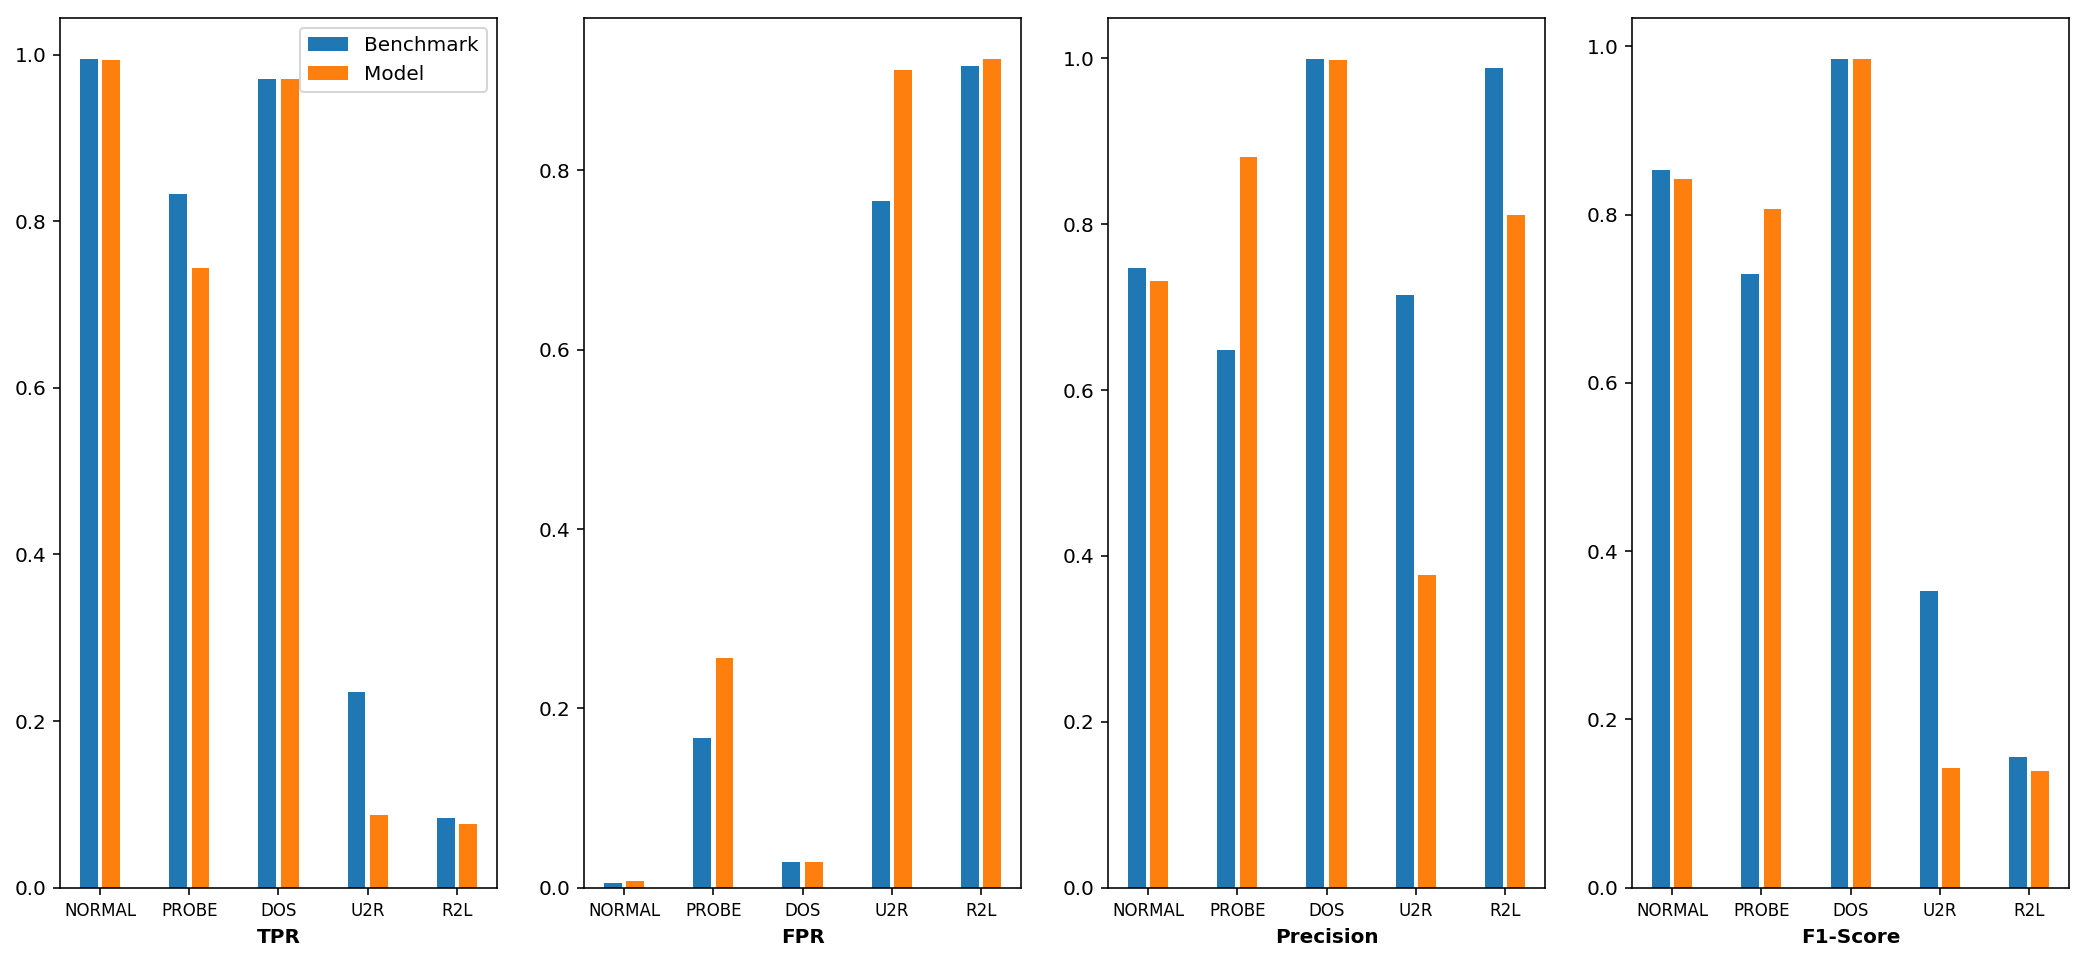

In [18]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
fig = hm.plotMetricsWithoutAccuracy(metrics)


In [19]:
print metrics

{'f1_bench': [0.8532068477131762, 0.7290485142967439, 0.9848039284638757, 0.35294117275017306, 0.15485340020699412], 'fpr_model': [0.006881983067351014, 0.2558809409505521, 0.028744458414725935, 0.9122807017543859, 0.9240224844029897], 'prec_bench': [0.747046499807852, 0.6480582524271845, 0.9988276775486827, 0.7142857142857143, 0.9883720930232558], 'tpr_bench': [0.994537322793062, 0.8331733077292367, 0.971168529451432, 0.234375, 0.08400765952189758], 'accuracy_bench': 0.92737891930312066, 'f1_model': [0.8421700777566691, 0.8066614574344885, 0.9845946170112723, 0.14234875138764713, 0.1389359523471956], 'fpr_bench': [0.005462677206938095, 0.16682669227076333, 0.028831470548567998, 0.765625, 0.9159923404781024], 'tpr_model': [0.993118016932649, 0.7441190590494479, 0.971255541585274, 0.08771929824561403, 0.07597751559701031], 'accuracy_model': 0.92522562204810477, 'prec_model': [0.7310542556551741, 0.8806818181818182, 0.9983051984348799, 0.37735849056603776, 0.8108108108108109]}
